# Can we predict magic the gatherin card price? 

This jupyter is a notebook to master the concepts explained in Hands-On Machine Learning with Scikit-Learn and Tensor Flow by Aurélien Géron.

Magic the gathering is trading card game released in 1993 by Richard Garfield. It's played by both adults and children. It's remarkable by its longevity but also the second hand market, place of speculation and trades. 

With real world data, can we predict what weight on the price the most?

First, i gather the data from https://scryfall.com/. It have an API, making collecting cards data easy. 

I've already written some code to collect them. You can find it in the Magic_card_fetcher folder. Let's gather the data, put them into a dataframe and look at them.

In [1]:
import pandas as pd
from real_exercice import Magic_card_fetcher

# Scryfall API give back a JSON making most of our values string. 

string_df = Magic_card_fetcher.get_all_standard()
string_df.head()

,all_parts,artist,border_color,card_faces,cmc,collector_number,color_identity,colors,colorshifted,digital,...,story_spotlight,timeshifted,tix,toughness,type_line,uri,usd,arena_id,watermark,mtgo_foil_id
0,NaN,Tomasz Jedruszek,black,NaN,2.0,85,[B],[B],False,False,...,False,False,0.01,NaN,Instant,https://api.scryfall.com/cards/de2de2bd-9ba7-4...,0.23,NaN,NaN,NaN
1,NaN,Eric Deschamps,black,NaN,3.0,127,[R],[R],False,False,...,False,False,0.01,NaN,Sorcery,https://api.scryfall.com/cards/9160dde8-cd77-4...,0.02,NaN,NaN,NaN
2,NaN,Anthony Palumbo,black,NaN,2.0,1,[W],[W],False,False,...,False,False,0.01,NaN,Instant,https://api.scryfall.com/cards/0503c55d-74bb-4...,0.03,NaN,NaN,NaN
3,NaN,Zoltan Boros,black,NaN,4.0,211,"[U, W]","[U, W]",False,False,...,False,False,0.01,4,Creature — Human Artificer,https://api.scryfall.com/cards/5314bae2-4930-4...,0.04,NaN,NaN,NaN
4,NaN,Izzy,black,NaN,4.0,2,[W],[W],False,False,...,False,False,0.01,3,Creature — Dwarf Artificer,https://api.scryfall.com/cards/226f7c45-db9f-4...,0.03,NaN,NaN,NaN


In [2]:
string_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1311 entries, 0 to 267
Data columns (total 58 columns):
all_parts            129 non-null object
artist               1311 non-null object
border_color         1311 non-null object
card_faces           28 non-null object
cmc                  1311 non-null float64
collector_number     1311 non-null object
color_identity       1311 non-null object
colors               1293 non-null object
colorshifted         1311 non-null bool
digital              1311 non-null bool
edhrec_rank          1273 non-null float64
eur                  1296 non-null object
flavor_text          964 non-null object
foil                 1311 non-null bool
frame                1311 non-null object
full_art             1311 non-null bool
futureshifted        1311 non-null bool
highres_image        1311 non-null bool
id                   1311 non-null object
illustration_id      1293 non-null object
image_uris           1293 non-null object
lang                 1311 

This is interesting! 

Though, even if people really like the art of a card, i'd doubt that artist name  drive a lot the prices. Let's choose variables that are relevant to the game (such as mana cost or type of card) and if it's a reprint to predict card price.

In [3]:
short_df = string_df[['colors','cmc','mana_cost','rarity',
                      'toughness', 'power', 'type_line', 'name', 
                      'reprint', 'usd']]
short_df.set_index('name', inplace=True)
short_df.head()

,colors,cmc,mana_cost,rarity,toughness,power,type_line,reprint,usd
name,,,,,,,,,
Abnormal Endurance,[B],2.0,{1}{B},common,NaN,NaN,Instant,False,0.23
Act of Treason,[R],3.0,{2}{R},common,NaN,NaN,Sorcery,True,0.02
Aegis of the Heavens,[W],2.0,{1}{W},uncommon,NaN,NaN,Instant,False,0.03
Aerial Engineer,"[U, W]",4.0,{2}{W}{U},uncommon,4,2,Creature — Human Artificer,False,0.04
Aethershield Artificer,[W],4.0,{3}{W},uncommon,3,3,Creature — Dwarf Artificer,False,0.03


This looks more easy!

I deliberatly chose to leave out the card text (the special rules), even if they're the most likely to predict the price. It's ground for more advanced techniques i will see later!

Now let's make a naive assumption. 

You can play cards in the game by paying their mana cost. The more you pay, the bigger the card effect is. So good card = big mana cost right? And thoses cards would be the most pricey!

To see this, let's convert cmc (total mana cost) and usd (price in dollars) into a float (they come from a JSON which is a string)

In [4]:
for items in ['cmc', 'usd']:
    short_df[items] = short_df[items].astype('float', copy=False)

C:\Users\kercy_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Now let's plot cmc against usd to see what it looks like.

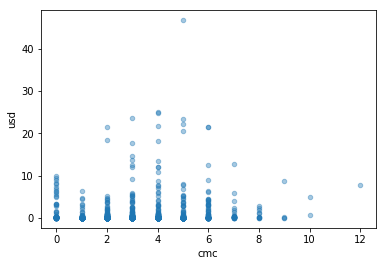

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
short_df.plot(kind='scatter', x ='cmc' , y = 'usd', alpha=0.4)
plt.show()

Uh oh, this doesn't look well. Let's look what it give when i do a linear regression

In [6]:
import sklearn.linear_model
import numpy as np

# I just prepare the data for the regression
dummy_df = short_df.loc[:,['cmc', 'usd']].dropna()

In [7]:
# Using a simple linear regression is easy!

model = sklearn.linear_model.LinearRegression()

x = np.c_[dummy_df['cmc']]
y = np.c_[dummy_df['usd']]

model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Our model is set!

Let' look what it look like against our previous plot.

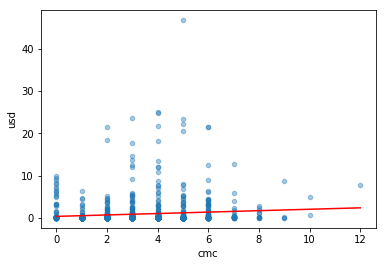

In [8]:
y_plot = []
for item in range(0,13):
    y_plot.append(float(model.predict(item)))
short_df.plot(kind='scatter', x ='cmc' , y = 'usd', alpha=0.4)
plt.plot(y_plot, color='r')
plt.show()

It looks pretty bad ahah! A linear regression on thoses two values doesn't help us reflect reality at all! We should use more data! 

Maybe more rare cards cost higher? 

# In construction : ) 

In [ ]:
mini_df = short_df[['cmc', 'usd','rarity']]
mini_df.head()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(mini_df["rarity"])

le.classes_

In [ ]:
mini_df['rarity'] = le.transform(mini_df['rarity'])

In [ ]:
mini_df.head()

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(mini_df, test_size=0.2, random_state = 42)